In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import (venn2, venn2_unweighted)

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [2]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [3]:
def rename_feats(features_to_use, taxonomy_18s_nosp,
                 taxonomy_mag, metab_ids, tables):
    
    index_dict = {'metabolite': [], 
                  'mag': [], 
                  '18S': [], 
                  'gene_module': [],
                  'metabolomics': []}
    modality_map = {}

    for ind_ in features_to_use:
        if ind_ in taxonomy_18s_nosp.index:
            label_ = taxonomy_18s_nosp.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['18S'].append(label_)
            modality_map[label_] = 'Eukaryotes (18S)'

        elif ind_ in taxonomy_mag.index:
            label_ = taxonomy_mag.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['mag'].append(label_)
            modality_map[label_] = 'Bacterial Genomes (MetaG)'
            
        elif ind_ in metab_ids.index:
            label_ = metab_ids.loc[ind_, 'most specific class']
            index_dict['metabolite'].append(label_)
            modality_map[label_] = 'Metabolites'
            
        else:
            if ind_ in tables['mag'].ids('observation'):
                index_dict['mag'].append(ind_)
                modality_map[ind_] = 'Bacterial Genomes (MetaG)'
            elif ind_ in tables['18S'].ids('observation'):
                index_dict['18S'].append(ind_)
                modality_map[ind_] = 'Eukaryotes (18S)'
            elif ind_ in tables['gene_module'].ids('observation'):
                index_dict['gene_module'].append(ind_)
                modality_map[ind_] = 'Functions (MetaG)'
            elif ind_ in tables['metabolomics'].ids('observation'):
                index_dict['metabolomics'].append(ind_)
                modality_map[ind_] = 'Metabolites'

    #clean lists in index_dict
    for modality, feature in index_dict.items():
        clean_lst = ['drop' if len(str(i_)) == 0 else i_ for i_ in feature]
        clean_lst = ['drop' if str(i_) == 'nan' else i_ for i_ in clean_lst]
        clean_lst = [i_.replace('_',' ') for i_ in clean_lst]
        #drop features
        index_dict[modality] = [i_ for i_ in clean_lst if i_ != 'drop']

    return index_dict

## Load data

In [4]:
#load rpca results
nPCs = 4
ord_18S = OrdinationResults.read('../results/joint-rpca/Ordinations/18S_ord_{}PCs.txt'.format(nPCs))
ord_mag = OrdinationResults.read('../results/joint-rpca/Ordinations/mag_ord_{}PCs.txt'.format(nPCs))
ord_gene = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_ord_{}PCs.txt'.format(nPCs))
ord_gene_module = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_module_ord_{}PCs.txt'.format(nPCs))
ord_metabolite = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(nPCs))
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [5]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom',
              'metabolomics':'../network/split-matched-data/metabolomics.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [6]:
# annots for tables
taxonomy_18s = pd.read_csv('../network/annotations/18S_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_18s = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_18s.index, taxonomy_18s.Taxon.values)}
taxonomy_18s = pd.DataFrame(taxonomy_18s).T
taxonomy_18s_nosp = taxonomy_18s.drop([' s'], axis=1)

taxonomy_mag = pd.read_csv('../network/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_mag = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_mag.index, taxonomy_mag.Taxon.values)}
taxonomy_mag = pd.DataFrame(taxonomy_mag).T
taxonomy_mag[taxonomy_mag == ''] = np.nan

metab_ids = pd.read_excel('../network/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

In [ ]:
# bt_tmp, df_tmp, ord_tmp = tables['metabolite']
# keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
# bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
# df_tmp = df_tmp.loc[list(keep_metab), :]
# ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use)
# tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

In [7]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


## Find overlapping features

In [6]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3','PC4']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_4PCs.csv'.format(pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [7]:
best_pc_per_task = {}

for task in ['facility', 'stage', 'season']:
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

In [8]:
#define parameters
quantile = 0.90
task = 'stage' #'season', 'facility', 'stage'
best_pc = best_pc_per_task[task]
best_pc

{'18S_Joint-RPCA': ('PC4', 0.3969722455845248),
 '18S_RPCA': ('PC2', 0.41604938271604935),
 'Gene_Joint-RPCA': ('PC2', 0.4361702127659574),
 'Gene_Module_Joint-RPCA': ('PC2', 0.42021276595744683),
 'Gene_Module_RPCA': ('PC2', 0.45212765957446804),
 'Gene_RPCA': ('PC2', 0.48404255319148937),
 'MAG_Joint-RPCA': ('PC2', 0.47311827956989244),
 'MAG_RPCA': ('PC3', 0.4414893617021276),
 'Metabolite_Joint-RPCA': ('PC2', 0.3882978723404255),
 'Metabolite_RPCA': ('PC2', 0.40957446808510634)}

In [50]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S_RPCA': ord_18S, 'MAG_RPCA': ord_mag, 'Gene_RPCA': ord_gene, 
            'Gene_Module_RPCA': ord_gene_module, 'Metabolite_RPCA': ord_metabolite}

rpca_top_fts = {}
rpca_bot_fts = {}

for omic_pc, omic_table in zip(rpca_ord.keys(), tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    ord_ = rpca_ord[omic_pc].features.copy()
    table_ = tables[omic_table]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_fts[omic_pc] = top_fts
    rpca_bot_fts[omic_pc] = bottom_fts

18S 18S_RPCA
mag MAG_RPCA
gene Gene_RPCA
gene_module Gene_Module_RPCA
metabolite Metabolite_RPCA


In [51]:
#find top features from joint-RPCA results
joint_pc_ids = ['{}_Joint-RPCA'.format(id.split('_')[0]) if 'Module' not in id else 'Gene_Module_Joint-RPCA'
                for id in rpca_ord.keys()]
joint_top_fts = {}
joint_bot_fts = {}

for omic_pc, omic_table in zip(joint_pc_ids, tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    table_ = tables[omic_table]
    if omic_table == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_fts[omic_pc] = top_fts
    joint_bot_fts[omic_pc] = bottom_fts

18S 18S_Joint-RPCA
mag MAG_Joint-RPCA
gene Gene_Joint-RPCA
gene_module Gene_Module_Joint-RPCA
metabolite Metabolite_Joint-RPCA


In [52]:
#RCPA TOP and Joint-RPCA TOP intersecting features
common_top_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_top_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 176
Total features: 26. Number of intersecting features for mag: 15
Total features: 246. Number of intersecting features for gene: 193
Total features: 38. Number of intersecting features for gene_module: 0
Total features: 234. Number of intersecting features for metabolite: 47


In [53]:
#RCPA TOP and Joint-RPCA BOTTOM intersecting features
common_top_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_top_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 127
Total features: 26. Number of intersecting features for mag: 0
Total features: 246. Number of intersecting features for gene: 0
Total features: 38. Number of intersecting features for gene_module: 27
Total features: 234. Number of intersecting features for metabolite: 23


In [54]:
#RCPA BOTTOM and Joint-RPCA BOTTOM intersecting features
common_bottom_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_bottom_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 110
Total features: 26. Number of intersecting features for mag: 12
Total features: 246. Number of intersecting features for gene: 190
Total features: 38. Number of intersecting features for gene_module: 0
Total features: 234. Number of intersecting features for metabolite: 25


In [55]:
#RCPA BOTTOM and Joint-RPCA TOP intersecting features
common_bottom_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_bottom_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 151
Total features: 26. Number of intersecting features for mag: 0
Total features: 246. Number of intersecting features for gene: 0
Total features: 38. Number of intersecting features for gene_module: 32
Total features: 234. Number of intersecting features for metabolite: 24


In [56]:
#find intersecting bottom features
common_top_bot_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
    common_fts = set(rpca_top_bot).intersection(joint_top_bot)
    common_top_bot_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(rpca_top_bot), omic_id, len(common_fts)))

Total features: 1087. Number of intersecting features for 18S: 564
Total features: 52. Number of intersecting features for mag: 27
Total features: 492. Number of intersecting features for gene: 383
Total features: 76. Number of intersecting features for gene_module: 59
Total features: 468. Number of intersecting features for metabolite: 119


## Plotting

In [57]:
#find the average ranks of the intersecting features
avg_ranks_common_top = {}
avg_ranks_common_bottom = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    top_ranks_rpca = []
    top_ranks_joint = []

    bottom_ranks_rpca = []
    bottom_ranks_joint = []

    for ft in common_top_bot_fts[omic_id]:

        #check rank in rpca
        if ft in rpca_top_fts[omic_rpca]:
            r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
            top_ranks_rpca.append(r_rpca)
        elif ft in rpca_bot_fts[omic_rpca]:
            r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
            bottom_ranks_rpca.append(r_rpca)

        #check rank in joint-rpca
        if ft in joint_top_fts[omic_joint]:
            r_joint = joint_top_fts[omic_joint].index(ft) + 1
            top_ranks_joint.append(r_rpca)
        elif ft in joint_bot_fts[omic_joint]:
            r_joint = joint_bot_fts[omic_joint].index(ft) + 1
            bottom_ranks_joint.append(r_rpca)
        
    avg_ranks_common_top[omic_id] = (np.mean(top_ranks_rpca), 
                              np.mean(top_ranks_joint))
    avg_ranks_common_bottom[omic_id] = (np.mean(bottom_ranks_rpca), 
                                 np.mean(bottom_ranks_joint))

In [58]:
avg_ranks_top_rpca_only = {}
avg_ranks_bottom_rpca_only = {}

for omic_rpca, omic_id in zip(rpca_ord.keys(), tables.keys()):
    ranks_top_rpca_only = []
    ranks_bot_rpca_only = []

    #get features unique to RPCA 
    rpca_only_top = set(rpca_top_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    rpca_only_bot = set(rpca_bot_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to RPCA for %s: %i" % (omic_id, len(rpca_only_top)+len(rpca_only_bot)))
    for ft in rpca_only_top:
        r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
        ranks_top_rpca_only.append(r_rpca)
    
    for ft in rpca_only_bot:
        r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
        ranks_bot_rpca_only.append(r_rpca)
        
    avg_ranks_top_rpca_only[omic_id] = np.mean(ranks_top_rpca_only)
    avg_ranks_bottom_rpca_only[omic_id] = np.mean(ranks_bot_rpca_only)

Number of features unique to RPCA for 18S: 523
Number of features unique to RPCA for mag: 25
Number of features unique to RPCA for gene: 109
Number of features unique to RPCA for gene_module: 17
Number of features unique to RPCA for metabolite: 349


In [59]:
avg_ranks_top_joint_only = {}
avg_ranks_bottom_joint_only = {}

for omic_joint, omic_id in zip(joint_pc_ids, tables.keys()):
    ranks_top_joint_only = []
    ranks_bot_joint_only = []

    #get features unique to RPCA 
    joint_only_top = set(joint_top_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    joint_only_bot = set(joint_bot_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_only_top)+len(joint_only_bot)))
    for ft in joint_only_top:
        r_joint = joint_top_fts[omic_joint].index(ft) + 1
        ranks_top_joint_only.append(r_joint)
    
    for ft in joint_only_bot:
        r_joint = joint_bot_fts[omic_joint].index(ft) + 1
        ranks_bot_joint_only.append(r_joint)
        
    avg_ranks_top_joint_only[omic_id] = np.mean(ranks_top_joint_only)
    avg_ranks_bottom_joint_only[omic_id] = np.mean(ranks_bot_joint_only)

Number of features unique to Joint-RPCA for 18S: 524
Number of features unique to Joint-RPCA for mag: 25
Number of features unique to Joint-RPCA for gene: 109
Number of features unique to Joint-RPCA for gene_module: 17
Number of features unique to Joint-RPCA for metabolite: 349


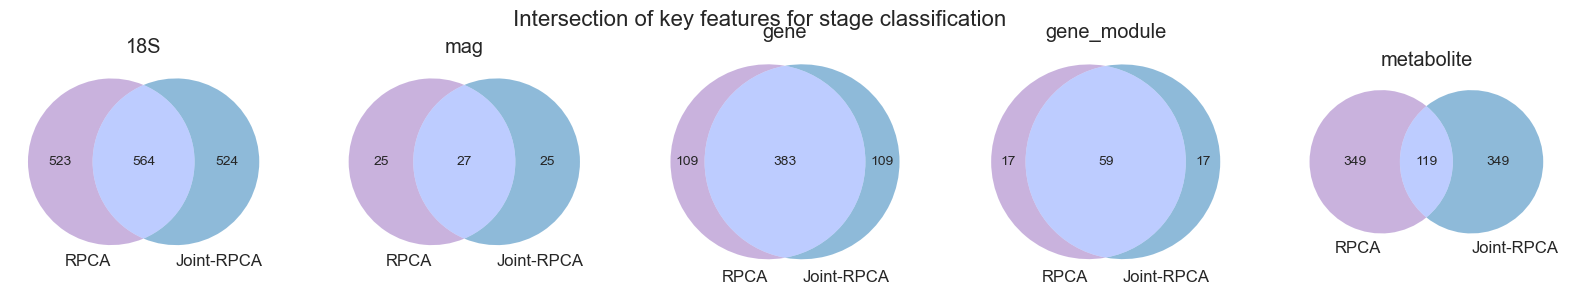

In [60]:
#plot a venn diagram per omic
fig, axn = plt.subplots(1, 5, figsize=(20, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables.keys(),
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
                                                         
    a = len(rpca_top_bot) - len(common_top_bot_fts[omic_id])
    b = len(common_top_bot_fts[omic_id])
    c = len(joint_top_bot) - len(common_top_bot_fts[omic_id])

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.8)
#plt.tight_layout()
plt.show()

In [61]:
#create table with top and bottom ranks
#Common features: avg_ranks_common_top, avg_ranks_common_bottom
#RPCA only: avg_ranks_top_rpca_only, avg_ranks_bottom_rpca_only
#Joint-RPCA only: avg_ranks_top_joint_only, avg_ranks_bottom_joint_only

#top ranks
top_ranks = pd.DataFrame(columns=['Omic', 'RPCA Only', 'RPCA Common', 
                                  'Joint-RPCA Common', 'Joint-RPCA Only'])
for omic_id in tables.keys():
    top_ranks = top_ranks._append({'Omic': omic_id, 
                                   'RPCA Only': round(avg_ranks_top_rpca_only[omic_id], 2),
                                   'RPCA Common': round(avg_ranks_common_top[omic_id][0], 2),
                                   'Joint-RPCA Common': round(avg_ranks_common_top[omic_id][1], 2),
                                   'Joint-RPCA Only': round(avg_ranks_top_joint_only[omic_id], 2)}, 
                                   ignore_index=True)
top_ranks.set_index('Omic', inplace=True)

#bottom ranks
bottom_ranks = pd.DataFrame(columns=['Omic', 'RPCA Only', 'RPCA Common', 
                                     'Joint-RPCA Common', 'Joint-RPCA Only'])
for omic_id in tables.keys():
    bottom_ranks = bottom_ranks._append({'Omic': omic_id, 
                                         'RPCA Only': round(avg_ranks_bottom_rpca_only[omic_id], 2),
                                         'RPCA Common': round(avg_ranks_common_bottom[omic_id][0], 2),
                                         'Joint-RPCA Common': round(avg_ranks_common_bottom[omic_id][1], 2),
                                         'Joint-RPCA Only': round(avg_ranks_bottom_joint_only[omic_id], 2)}, 
                                         ignore_index=True)
bottom_ranks.set_index('Omic', inplace=True)


In [62]:
print("Ranks of top features:")
display(top_ranks.T)
print()
print("Ranks of bottom features:")
display(bottom_ranks.T)

Ranks of top features:


Omic,18S,mag,gene,gene_module,metabolite
RPCA Only,338.23,15.36,181.62,31.09,120.52
RPCA Common,220.22,12.13,107.54,14.78,110.43
Joint-RPCA Common,250.39,12.13,107.54,22.19,125.28
Joint-RPCA Only,327.62,19.45,162.17,23.83,124.42



Ranks of bottom features:


Omic,18S,mag,gene,gene_module,metabolite
RPCA Only,197.13,8.50,84.25,5.17,111.36
RPCA Common,352.90,19.33,135.07,22.19,140.67
Joint-RPCA Common,324.70,19.33,135.07,14.78,119.33
Joint-RPCA Only,230.79,10.14,78.52,15.00,116.04


## RPCA and Joint-RPCA
Top 20 and bottom 20 features

In [7]:
#load json files
with open('../results/joint-rpca/Original/joint_decomposer_feats.json', 'r') as f:
    joint_feats = json.load(f)

with open('../results/joint-rpca/Original/rpca_decomposer_feats.json', 'r') as f:
    rpca_feats = json.load(f)

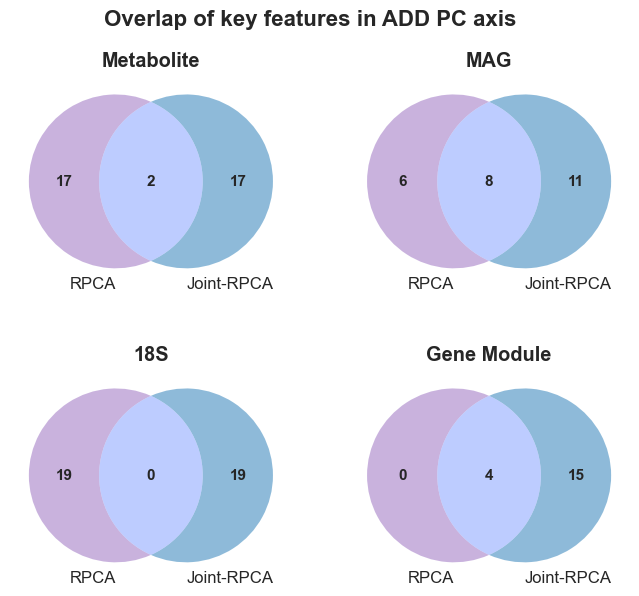

Overlapping features:
{'metabolite': {'metab_350', 'metab_2325'}, 'mag': {'UTK.bins.50', 'UTK.bins.71', 'CMU.bins.224', 'SHSU.bins.175', 'SHSU.bins.319', 'UTK.bins.19', 'UTK_active.final.26', 'SHSU.bins.42'}, '18S': set(), 'gene_module': {'Type_I_signiture_cas_proteins', 'D-Methionine_transport_system', 'Na_-transporting_0DH:ubiquinone_oxidoreductase-', 'RNF_complex'}}


In [8]:
#plot a venn diagram per omic
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}
overlap_feats_omic = {}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), joint_feats.keys()):
    
    ##check overlap between
    rpca_feats_all = rpca_feats[omic_id][1]
    joint_feats_all = joint_feats[omic_id][0]

    overlap_feats = set(rpca_feats_all).intersection(set(joint_feats_all))
    overlap_feats_omic[omic_id] = overlap_feats
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(joint_feats_all) - len(overlap_feats)

    v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of key features in ADD PC axis', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

print("Overlapping features:")
print(overlap_feats_omic)

In [9]:
#concat all top features in dictionary
all_overlap_feats = []
all_feats_rpca = []
all_feats_joint = []

for omic_id in overlap_feats_omic.keys():
    #rpca_feats_ = np.concatenate(rpca_feats[omic_id])
    #rpca_feats_ = rpca_feats[omic_id][0]
    #all_feats_rpca.extend(rpca_feats_)
    #joint_feats_ = np.concatenate(joint_feats[omic_id])
    #joint_feats_ = joint_feats[omic_id][0]
    #all_feats_joint.extend(joint_feats_)
    all_overlap_feats.extend(overlap_feats_omic[omic_id])

In [10]:
#rpca_feats_renamed = rename_feats(all_feats_rpca, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
#joint_feats_renamed = rename_feats(all_feats_joint, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
overlap_feats_renamed = rename_feats(all_overlap_feats, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)

In [11]:
for omic_id in overlap_feats_renamed.keys():
    if len(overlap_feats_renamed[omic_id]) > 0:
        print("{}: {} overlapped feats".format(omic_id,len(overlap_feats_renamed[omic_id])))
        print(overlap_feats_renamed[omic_id])
        print()

metabolite: 2 overlapped feats
['Fatty acids and conjugates', 'Benzene and substituted derivatives']

mag: 8 overlapped feats
['Peptoniphilaceae (f)', 'Savagea sp009740415 (s)', 'Tissierellales (o)', 'Ignatzschineria cameli (s)', 'Catellicoccaceae (f)', 'Bacteroides E (g)', 'Savagea sp009740415 (s)', 'Planococcaceae (f)']

gene_module: 4 overlapped feats
['Type I signiture cas proteins', 'D-Methionine transport system', 'Na -transporting 0DH:ubiquinone oxidoreductase-', 'RNF complex']



## Overlap with Decomposer Network
Use best PCs based on KW results

In [61]:
#load decomposer network features
decomposer_initial = pd.read_csv('../results/joint-rpca/decomposer_network_features_initial-associated.csv', 
                                 index_col=0, header=0, names=['features'])
print("Initial decomposer network features: %i" % len(decomposer_initial))

Initial decomposer network features: 60


In [62]:
decomposer_advanced = pd.read_csv('../results/joint-rpca/Original/decomposer_network_features_advanced-associated.csv', 
                                  index_col=0, header=0, names=['features'])
print("Advanced decomposer network features: %i" % len(decomposer_advanced))

Advanced decomposer network features: 63


In [63]:
#separate features by omic
decomposer_initial_omics = {}
decomposer_advanced_omics = {}

for omic in tables.keys():
    #get omic features
    omic_features = tables[omic].ids(axis='observation')
    omic_fts_decomposer = []
    for ft in decomposer_initial.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_initial_omics[omic] = omic_fts_decomposer

    #repeat for advanced
    omic_fts_decomposer = []
    for ft in decomposer_advanced.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_advanced_omics[omic] = omic_fts_decomposer

In [64]:
#sanity check
for omic in tables.keys():
    print(omic, len(decomposer_initial_omics[omic]), len(decomposer_advanced_omics[omic]))

18S 12 9
mag 16 17
gene 0 0
gene_module 18 19
metabolite 14 18
metabolomics 14 18


### Version 1: Top and bottom 10% features

In [13]:
#best PCs based on KW results: stage - (season + facility)
best_pc_per_task_kw = {'18S_Joint-RPCA': 'PC2',
                        '18S_RPCA': 'PC4',
                        #'Gene_Joint-RPCA': 'PC2', #no genes in decomposer network
                        #'Gene_RPCA': 'PC2',
                        'Gene_Module_Joint-RPCA': 'PC2',
                        'Gene_Module_RPCA': 'PC2',
                        'MAG_Joint-RPCA': 'PC2',
                        'MAG_RPCA': 'PC3',
                        'Metabolite_Joint-RPCA': 'PC2',
                        'Metabolite_RPCA': 'PC2'}

task = 'stage'
tables_keys = ['18S', 'mag', 'gene_module', 'metabolite']
quantile = 0.9

In [14]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S_RPCA': ord_18S, 'MAG_RPCA': ord_mag, #'Gene_RPCA': ord_gene, 
            'Gene_Module_RPCA': ord_gene_module, 'Metabolite_RPCA': ord_metabolite}

rpca_top_fts = {}
rpca_bot_fts = {}

for omic_pc, omic_table in zip(rpca_ord.keys(), tables_keys):

    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc_per_task_kw[omic_pc]
    ord_ = rpca_ord[omic_pc].features.copy()
    table_ = tables[omic_table]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_fts[omic_pc] = top_fts
    rpca_bot_fts[omic_pc] = bottom_fts

18S 18S_RPCA
mag MAG_RPCA
gene_module Gene_Module_RPCA
metabolite Metabolite_RPCA


In [15]:
#find top features from joint-RPCA results
joint_pc_ids = ['{}_Joint-RPCA'.format(id.split('_')[0]) if 'Module' not in id else 'Gene_Module_Joint-RPCA'
                for id in rpca_ord.keys()]
joint_top_fts = {}
joint_bot_fts = {}

for omic_pc, omic_table in zip(joint_pc_ids, tables_keys):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc_per_task_kw[omic_pc]
    table_ = tables[omic_table]
    if omic_table == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_fts[omic_pc] = top_fts
    joint_bot_fts[omic_pc] = bottom_fts

18S 18S_Joint-RPCA
mag MAG_Joint-RPCA
gene_module Gene_Module_Joint-RPCA
metabolite Metabolite_Joint-RPCA


### Early decomposition network

In [13]:
#RCPA and Joint-RPCA TOP features & decomposer (initial-associated)
common_top_fts_rpca_decomposer_initial = {}
common_top_fts_joint_decomposer_initial = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):
    
    common_fts_rpca = set(rpca_top_fts[omic_rpca]).intersection(decomposer_initial_omics[omic_id])
    common_top_fts_rpca_decomposer_initial[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_top_fts[omic_joint]).intersection(decomposer_initial_omics[omic_id])
    common_top_fts_joint_decomposer_initial[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_top_fts_rpca_decomposer_initial[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_top_fts_joint_decomposer_initial[omic_joint])))

Number of intersecting features with 18S_RPCA: 1
Number of intersecting features with 18S_Joint-RPCA: 0
Number of intersecting features with MAG_RPCA: 5
Number of intersecting features with MAG_Joint-RPCA: 14
Number of intersecting features with Gene_Module_RPCA: 0
Number of intersecting features with Gene_Module_Joint-RPCA: 18
Number of intersecting features with Metabolite_RPCA: 4
Number of intersecting features with Metabolite_Joint-RPCA: 2


In [14]:
#RCPA and Joint-RPCA BOTTOM features & decomposer (initial-associated)
common_bot_fts_rpca_decomposer_initial = {}
common_bot_fts_joint_decomposer_initial = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):
    
    common_fts_rpca = set(rpca_bot_fts[omic_rpca]).intersection(decomposer_initial_omics[omic_id])
    common_bot_fts_rpca_decomposer_initial[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_bot_fts[omic_joint]).intersection(decomposer_initial_omics[omic_id])
    common_bot_fts_joint_decomposer_initial[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_bot_fts_rpca_decomposer_initial[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_bot_fts_joint_decomposer_initial[omic_joint])))

Number of intersecting features with 18S_RPCA: 0
Number of intersecting features with 18S_Joint-RPCA: 0
Number of intersecting features with MAG_RPCA: 0
Number of intersecting features with MAG_Joint-RPCA: 0
Number of intersecting features with Gene_Module_RPCA: 16
Number of intersecting features with Gene_Module_Joint-RPCA: 0
Number of intersecting features with Metabolite_RPCA: 3
Number of intersecting features with Metabolite_Joint-RPCA: 0


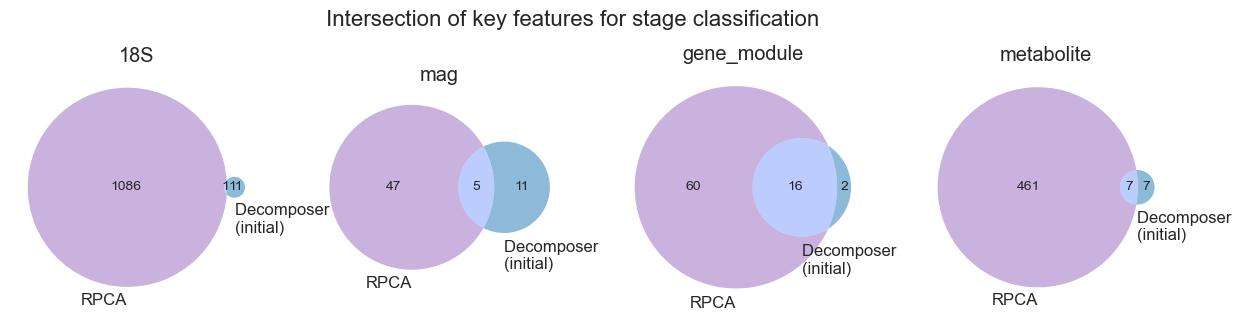

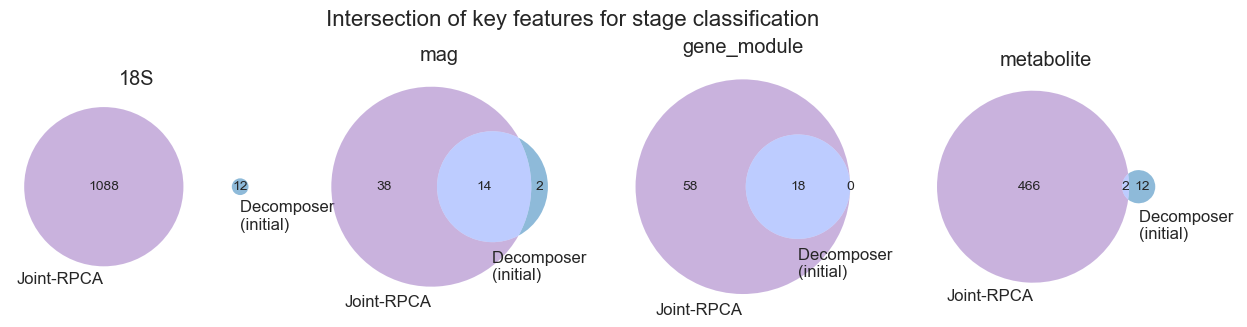

In [15]:
#plot a venn diagram per omic for decomposer (initial-associated)
#RPCA
fig, axn = plt.subplots(1, 4, figsize=(15, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    rpca_top_bot_decomposer = set(common_top_fts_rpca_decomposer_initial[omic_rpca]).union(set(common_bot_fts_rpca_decomposer_initial[omic_rpca]))
                                                         
    a = len(rpca_top_bot) - len(rpca_top_bot_decomposer)
    b = len(rpca_top_bot_decomposer)
    c = len(decomposer_initial_omics[omic_id]) - len(rpca_top_bot_decomposer)

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Decomposer \n(initial)'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.85)
#plt.tight_layout()
plt.show()

#JOINT-RPCA
fig, axn = plt.subplots(1, 4, figsize=(15, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
    joint_top_bot_decomposer = set(common_top_fts_joint_decomposer_initial[omic_joint]).union(set(common_bot_fts_joint_decomposer_initial[omic_joint]))
                                                         
    a = len(joint_top_bot) - len(joint_top_bot_decomposer)
    b = len(joint_top_bot_decomposer)
    c = len(decomposer_initial_omics[omic_id]) - len(joint_top_bot_decomposer)

    venn2(subsets=(a, c, b), set_labels=('Joint-RPCA', 'Decomposer \n(initial)'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.85)
#plt.tight_layout()
plt.show()

### Late decomposition network

In [15]:
#RCPA and Joint-RPCA TOP features & decomposer (advanced-associated)
common_top_fts_rpca_decomposer_advanced = {}
common_top_fts_joint_decomposer_advanced = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):

    common_fts_rpca = set(rpca_top_fts[omic_rpca]).intersection(decomposer_advanced_omics[omic_id])
    common_top_fts_rpca_decomposer_advanced[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_top_fts[omic_joint]).intersection(decomposer_advanced_omics[omic_id])
    common_top_fts_joint_decomposer_advanced[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_top_fts_rpca_decomposer_advanced[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_top_fts_joint_decomposer_advanced[omic_joint])))

In [17]:
#RCPA and Joint-RPCA BOTTOM features & decomposer (advanced-associated)
common_bot_fts_rpca_decomposer_advanced = {}
common_bot_fts_joint_decomposer_advanced = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables_keys):

    common_fts_rpca = set(rpca_bot_fts[omic_rpca]).intersection(decomposer_advanced_omics[omic_id])
    common_bot_fts_rpca_decomposer_advanced[omic_rpca] = common_fts_rpca
    
    common_fts_joint = set(joint_bot_fts[omic_joint]).intersection(decomposer_advanced_omics[omic_id])
    common_bot_fts_joint_decomposer_advanced[omic_joint] = common_fts_joint
    
    print("Number of intersecting features with %s: %i" % (omic_rpca,
                                                           len(common_bot_fts_rpca_decomposer_advanced[omic_rpca])))
    print("Number of intersecting features with %s: %i" % (omic_joint,
                                                           len(common_bot_fts_joint_decomposer_advanced[omic_joint])))

Number of intersecting features with 18S_RPCA: 3
Number of intersecting features with 18S_Joint-RPCA: 0
Number of intersecting features with MAG_RPCA: 0
Number of intersecting features with MAG_Joint-RPCA: 0
Number of intersecting features with Gene_Module_RPCA: 18
Number of intersecting features with Gene_Module_Joint-RPCA: 0
Number of intersecting features with Metabolite_RPCA: 1
Number of intersecting features with Metabolite_Joint-RPCA: 0


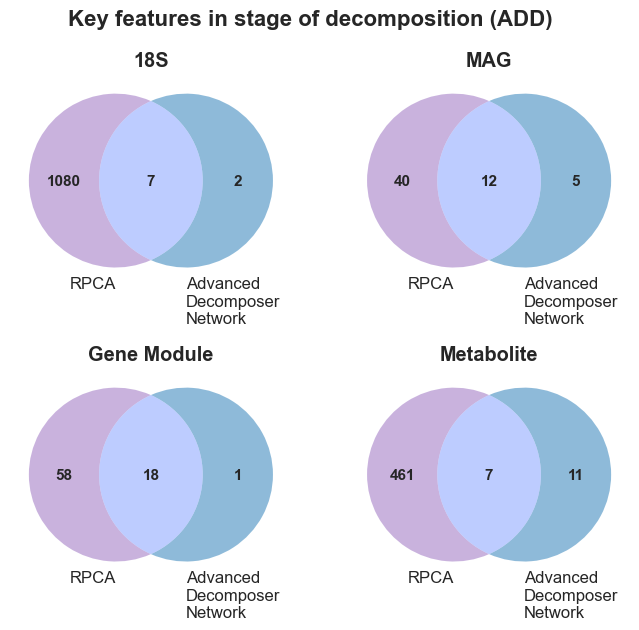

In [21]:
#plot a venn diagram per omic for decomposer (advanced-associated)
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables_keys,
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    rpca_top_bot_decomposer = set(common_top_fts_rpca_decomposer_advanced[omic_rpca]).union(set(common_bot_fts_rpca_decomposer_advanced[omic_rpca]))
                                                         
    a = len(rpca_top_bot) - len(rpca_top_bot_decomposer)
    b = len(rpca_top_bot_decomposer)
    c = len(decomposer_advanced_omics[omic_id]) - len(rpca_top_bot_decomposer)

    v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), ax=ax_,
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Key features in stage of decomposition (ADD)'.format(task), 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
            dpi=600, bbox_inches='tight', format='pdf')
plt.show()

Unique to Joint-RPCA for 18S: 9
['5762fbdafca096037872f442ab771c93', '21403936c8146cb545ac3a3854ceec31', '4ba629958d8066a41ed7d8d3af839653', '6188e3bdd766dfe2a5998f9206afe127', '7d41d94d8409a2fb21d04e19b8141333', 'b7493926527a25494179aa6f25f088b5', '32794c9125af0f00b2f95ce56025c220', 'cb007d7071ba8180be246bfa8f745397', '1bf1f0a861f411b0851c7cfefff7d931']
Shared features: 0
[]

Unique to Joint-RPCA for mag: 7
['SHSU.bins.50', 'SHSU.bins.354', 'SHSU.bins.450', 'UTK_active.final.18', 'UTK.bins.107', 'SHSU.bins.123', 'SHSU.bins.195']
Shared features: 10
['CMU.bins.248', 'CMU.bins.224', 'SHSU.bins.175', 'SHSU.bins.319', 'CMU_advanced.final.11', 'UTK.bins.50', 'UTK.bins.19', 'UTK_active.final.26', 'SHSU.bins.42', 'SHSU_advanced.final.35']

Unique to Joint-RPCA for gene_module: 4
['Fluoroquinolone_transport_system', 'R0_polymerase_archaea', 'Carbazole_degradation_carbazole_to_2-oxopent-4-enoate___anthranilate', 'Ornithine_biosynthesis_mediated_by_LysW_glutamate_to_ornithine']
Shared features:

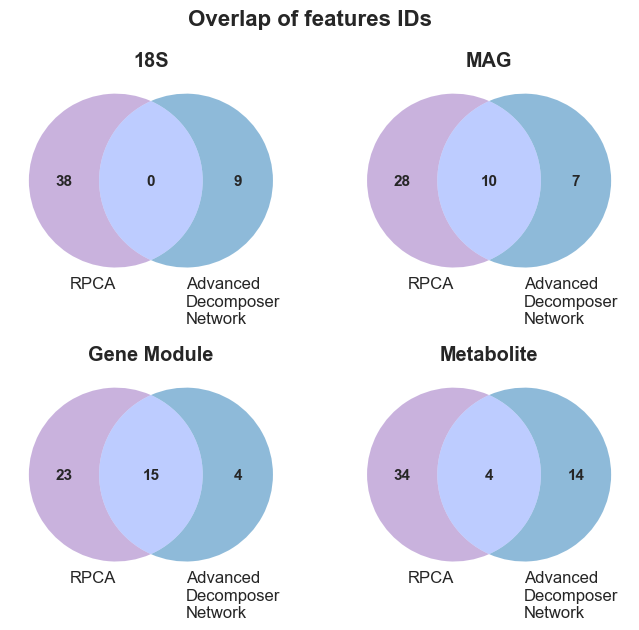

In [96]:
##overlap between 38 features (RPCA) and decomposer network
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), ['18S', 'mag', 'gene_module', 'metabolite']):
    
    rpca_feats_all = set(np.concatenate(rpca_feats[omic_id]))
    decomposer_ = set(decomposer_advanced_omics[omic_id])
    overlap_feats = set(rpca_feats_all).intersection(set(decomposer_))
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(decomposer_) - len(overlap_feats)

    joint_unique = set(decomposer_).difference(set(rpca_feats_all))
    print("Unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_unique)))
    print(list(joint_unique))
    print("Shared features: %i" % len(overlap_feats))
    print(list(overlap_feats))
    print()

    v = venn2_unweighted(subsets=(a, c, b), ax=ax_,
                         set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), 
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of features IDs', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

Unique to Joint-RPCA for 18S: 8
['Eurotiales ( os)', 'Animalia ( k)', 'Yarrowia ( g)', 'Candida ( g)', 'Apiotrichum ( g)', 'Geotrichum ( g)', 'Debaryomycetaceae ( fs)', 'Trichosporonaceae ( fs)']
Shared features: 1
['Rhabditida ( g)']

Unique to Joint-RPCA for mag: 7
['Morganella morganii (s)', 'Klebsiella pneumoniae (s)', 'Acinetobacter rudis (s)', 'Acinetobacter baumannii B (s)', 'Ignatzschineria (g)', 'Wohlfahrtiimonadaceae (f)', 'Oblitimonas alkaliphila (s)']
Shared features: 10
['Ignatzschineria larvae (s)', 'Tissierellales (o)', 'Peptoniphilaceae (f)', 'Planococcaceae (f)', 'Wohlfahrtiimonas chitiniclastica (s)', 'Vagococcus A lutrae (s)', 'Savagea sp009740415 (s)', 'Catellicoccaceae (f)', 'Bacteroides E (g)', 'Ignatzschineria cameli (s)']

Unique to Joint-RPCA for gene_module: 4
['Ornithine biosynthesis mediated by LysW glutamate to ornithine', 'R0 polymerase archaea', 'Fluoroquinolone transport system', 'Carbazole degradation carbazole to 2-oxopent-4-enoate   anthranilate']
Sha

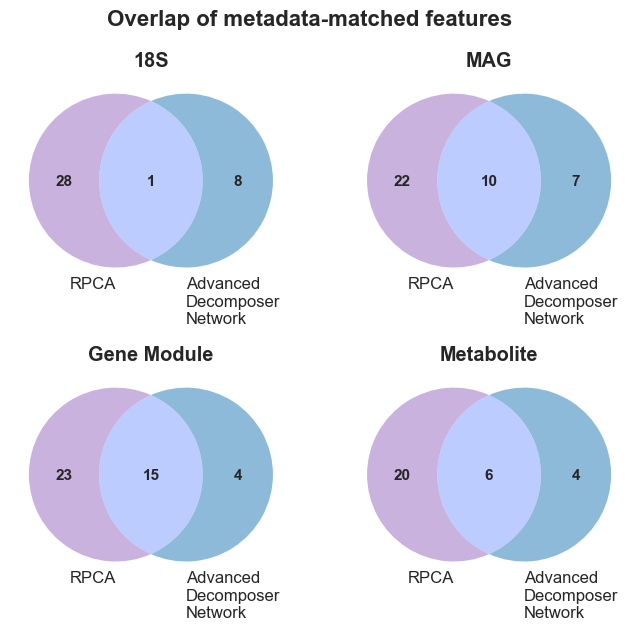

In [97]:
##overlap between 38 features (RPCA) and decomposer network
decomposer_advanced_renamed = rename_feats(decomposer_advanced.features, 
                                           taxonomy_18s_nosp, taxonomy_mag, 
                                           metab_ids, tables)

omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), ['18S', 'mag', 'gene_module', 'metabolite']):
    
    rpca_feats_all = set(rpca_feats_renamed[omic_id])
    decomposer_ = set(decomposer_advanced_renamed[omic_id])
    overlap_feats = set(rpca_feats_all).intersection(set(decomposer_))
                                                         
    a = len(rpca_feats_all) - len(overlap_feats)
    b = len(overlap_feats)
    c = len(decomposer_) - len(overlap_feats)

    joint_unique = set(decomposer_).difference(set(rpca_feats_all))
    print("Unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_unique)))
    print(list(joint_unique))
    print("Shared features: %i" % len(overlap_feats))
    print(list(overlap_feats))
    print()

    v = venn2_unweighted(subsets=(a, c, b), ax=ax_,
                         set_labels=('RPCA', 'Advanced\nDecomposer\nNetwork'), 
                         set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    
    for text in v.set_labels:
       text.set_fontsize(12)
       #text.set_fontweight('bold')
    
    for text in v.subset_labels:
       text.set_fontsize(11)
       text.set_fontweight('bold')

    ax_.set_title(omic_title[omic_id], weight='bold')
    plt.suptitle('Overlap of metadata-matched features', 
                 fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

### Literature review

In [17]:
for omic in decomposer_advanced_omics.keys():
    print(omic, len(decomposer_advanced_omics[omic]))
    print(decomposer_advanced_omics[omic])
    print()

18S 9
['b7493926527a25494179aa6f25f088b5', '32794c9125af0f00b2f95ce56025c220', '1bf1f0a861f411b0851c7cfefff7d931', 'cb007d7071ba8180be246bfa8f745397', '7d41d94d8409a2fb21d04e19b8141333', '4ba629958d8066a41ed7d8d3af839653', '5762fbdafca096037872f442ab771c93', '6188e3bdd766dfe2a5998f9206afe127', '21403936c8146cb545ac3a3854ceec31']

mag 17
['SHSU.bins.450', 'UTK.bins.107', 'UTK.bins.19', 'SHSU.bins.319', 'SHSU.bins.195', 'SHSU.bins.175', 'CMU.bins.248', 'SHSU.bins.50', 'SHSU.bins.123', 'UTK_active.final.18', 'UTK.bins.50', 'SHSU.bins.42', 'UTK_active.final.26', 'CMU.bins.224', 'SHSU_advanced.final.35', 'SHSU.bins.354', 'CMU_advanced.final.11']

gene 0
[]

gene_module 19
['0DH:ubiquinone_oxidoreductase_mitochondria', 'Adhesin_protein_transport_system', 'Arginine/lysine/histidine/glutamine_transport_system', 'Arginine/ornithine_transport_system', 'Carbazole_degradation_carbazole_to_2-oxopent-4-enoate___anthranilate', 'Cytochrome_o_ubiquinol_oxidase', 'D-Methionine_transport_system', 'D0_pol

In [18]:
#load taxonomy annotations
taxonomy_18S = pd.read_csv('../network/annotations/18S_taxonomy.tsv', sep='\t', index_col=0, header=0) ##Feature ID
taxonomy_mag = pd.read_csv('../network/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0, header=0) ##Feature ID
taxonomy_metabolite = pd.read_excel('../network/annotations/metabolite_formulas.xlsx', index_col=0, header=0) ##MetaboliteID, add 'metab_' prefix to match
taxonomy_metabolite.index = ['metab_'+str(i) for i in taxonomy_metabolite.index]

In [19]:
matched_metabolites = list(set(taxonomy_metabolite.index).intersection(set(decomposer_advanced_omics['metabolite'])))
print("Number of matched metabolites: %i" % len(matched_metabolites))
print(matched_metabolites)
print()
unmatched_metabolites = list(set(decomposer_advanced_omics['metabolite']) - set(taxonomy_metabolite.index))
print("Number of unmatched metabolites: %i" % len(unmatched_metabolites))
print(unmatched_metabolites)

Number of matched metabolites: 10
['metab_560', 'metab_443', 'metab_487', 'metab_350', 'metab_1884', 'metab_512', 'metab_2874', 'metab_150', 'metab_669', 'metab_2325']

Number of unmatched metabolites: 8
['metab_141', 'metab_2163', 'metab_1458', 'metab_541', 'metab_156', 'metab_1885', 'metab_686', 'metab_679']


In [20]:
#keep only features in decomposer
taxonomy_18S_adv = taxonomy_18S.loc[decomposer_advanced_omics['18S']]
taxonomy_mag_adv = taxonomy_mag.loc[decomposer_advanced_omics['mag']]
taxonomy_metabolite_adv = taxonomy_metabolite.loc[matched_metabolites]

In [33]:
#find metabolites that are uniqueliy identified by joint-rpca
metab_rpca_all = set(rpca_top_fts['Metabolite_RPCA']).union(set(rpca_bot_fts['Metabolite_RPCA']))
metab_decomposer = set(common_top_fts_rpca_decomposer_advanced['Metabolite_RPCA']).union(set(common_bot_fts_rpca_decomposer_advanced['Metabolite_RPCA']))
metab_joint_rpca = set(decomposer_advanced_omics['metabolite']) - metab_decomposer

#sanity check
print("Top metabolites in RPCA:", len(metab_rpca_all))
print("Metabolites in decomposer network found with RPCA:", len(metab_decomposer))
print("Metabolites in decomposer network found with Joint-RPCA:", len(metab_joint_rpca))

Top metabolites in RPCA: 468
Metabolites in decomposer network found with RPCA: 7
Metabolites in decomposer network found with Joint-RPCA: 11


In [34]:
#keep only metabolites that are in metadata
metab_joint_rpca_sub = [metab for metab in metab_joint_rpca if metab in taxonomy_metabolite_adv.index]
taxonomy_metab_joint = taxonomy_metabolite.loc[list(metab_joint_rpca_sub)]
display(taxonomy_metab_joint)
print(taxonomy_metab_joint.library_hit.values)

,library_hit,most specific class,level 5,subclass,class,superclass,all classifications,final_formula,van_krevlen_classification
metab_560,Suspect related to Spectral Match to Enterolac...,Curcuminoids,Curcuminoids,Linear diarylheptanoids,Diarylheptanoids,Phenylpropanoids and polyketides,Organic compounds; Lipids and lipid-like molec...,C10H20N8O2S,lipid
metab_350,Suspect related to Undecanedioic acid (predict...,Fatty acids and conjugates,0,Fatty acids and conjugates,Fatty Acyls,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...,C9H16O4,protein
metab_1884,NaN,Carboxylic acids,0,Carboxylic acids,Carboxylic acids and derivatives,Organic acids and derivatives,Organic compounds; Alcohols and polyols; Organ...,C16H28O3,lipid
metab_512,Suspect related to 14-Methylpentadecanoic acid...,Fatty acid esters,0,Fatty acid esters,Fatty Acyls,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...,C14H28O2,lipid
metab_2874,NaN,Medium-chain fatty acids,Medium-chain fatty acids,Fatty acids and conjugates,Fatty Acyls,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...,C12H22O2,lipid
metab_487,NaN,Fatty Acyls,0,0,Fatty Acyls,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...,C16H30O,lipid
metab_669,NaN,Monosaccharides,Monosaccharides,Carbohydrates and carbohydrate conjugates,Organooxygen compounds,Organic oxygen compounds,Organic compounds; Carbohydrates and carbohydr...,C16H33NO5,protein
metab_2325,NaN,Benzene and substituted derivatives,0,0,Benzene and substituted derivatives,Benzenoids,Organic compounds; Organoheterocyclic compound...,C10H22O4S,protein


['Suspect related to Spectral Match to Enterolactone from NIST14 (predicted molecular formula: C10H20N8O2S) with delta m/z 18.017 (putative explanation: unspecified; atomic difference: unspecified)'
 'Suspect related to Undecanedioic acid (predicted molecular formula: C9H16O4) with delta m/z -28.031 (putative explanation: Met->Cys substitution|Val->Ala substitution; atomic difference: -2C,-4H|-2C,-4H)'
 nan
 'Suspect related to 14-Methylpentadecanoic acid (predicted molecular formula: unknown) with delta m/z -28.031 (putative explanation: Met->Cys substitution|Val->Ala substitution; atomic difference: -2C,-4H|-2C,-4H)'
 nan nan nan nan]


In [35]:
#save metabolites identified by joint-rpca only
taxonomy_metab_joint.to_csv('../results/joint-rpca/adv_decomp_metab_joint-rpca_only.csv')

In [27]:
#display metabolites that are identified by both RPCA and Joint-RPCA
metab_joint_rpca_sub2 = [metab for metab in metab_decomposer if metab in taxonomy_metabolite_adv.index]
taxonomy_metab_rpca = taxonomy_metabolite.loc[list(metab_joint_rpca_sub2)]
display(taxonomy_metab_rpca)
print(taxonomy_metab_rpca.library_hit.values)

,library_hit,most specific class,level 5,subclass,class,superclass,all classifications,final_formula,van_krevlen_classification
metab_150,Suspect related to 16-Hydroxyhexadecanoic acid...,Fatty amides,0,Fatty amides,Fatty Acyls,Lipids and lipid-like molecules,Organic compounds; Lipids and lipid-like molec...,C16H33NO,lipid
metab_443,"1-Naphthaleneheptanoic acid, 1,2,6,7,8,8a-hexa...",Carbamate esters,Amino acids and derivatives,"Amino acids, peptides, and analogues",Carboxylic acids and derivatives,Organic acids and derivatives,Organic compounds; Organoheterocyclic compound...,C20H34N6O3,lipid


['Suspect related to 16-Hydroxyhexadecanoic acid (predicted molecular formula: unknown) with delta m/z 1.068 (putative explanation: unspecified; atomic difference: unspecified)'
 '1-Naphthaleneheptanoic acid, 1,2,6,7,8,8a-hexahydro-?,?-dihydroxy-2-methyl-8-(2-methyl-1-oxobutoxy)-, methyl ester_120185']


In [28]:
#find MAGs that are uniqueliy identified by joint-rpca
mag_rpca_all = set(rpca_top_fts['MAG_RPCA']).union(set(rpca_bot_fts['MAG_RPCA']))
mag_decomposer = set(common_top_fts_rpca_decomposer_advanced['MAG_RPCA']).union(set(common_bot_fts_rpca_decomposer_advanced['MAG_RPCA']))
mag_joint_rpca = set(decomposer_advanced_omics['mag']) - mag_decomposer

#sanity check
print("Top MAGs in RPCA:", len(mag_rpca_all))
print("MAGs in decomposer network found with RPCA:", len(mag_decomposer))
print("MAGs in decomposer network found with Joint-RPCA:", len(mag_joint_rpca))

Top MAGs in RPCA: 52
MAGs in decomposer network found with RPCA: 12
MAGs in decomposer network found with Joint-RPCA: 5


In [36]:
#keep only MAGs that are in metadata
mag_joint_rpca_sub = [mag for mag in mag_joint_rpca if mag in taxonomy_mag_adv.index]
taxonomy_mag_joint = taxonomy_mag.loc[list(mag_joint_rpca_sub)]
display(taxonomy_mag_joint)
print(taxonomy_mag_joint.Taxon.values)

,Taxon,Confidence
Feature ID,,
SHSU.bins.195,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
SHSU.bins.450,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
UTK.bins.107,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
SHSU.bins.354,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
SHSU.bins.123,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100


['d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Wohlfahrtiimonadaceae;g__Ignatzschineria;s__'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter baumannii_B'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter;s__Acinetobacter rudis'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Wohlfahrtiimonadaceae;g__;s__'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Morganella;s__Morganella morganii']


In [37]:
#save MAGs identified by joint-rpca only
taxonomy_mag_joint.to_csv('../results/joint-rpca/adv_decomp_MAG_joint-rpca_only.csv')

In [30]:
#display MAGs identified by both RPCA and Joint-RPCA
mag_joint_rpca_sub2 = [mag for mag in mag_decomposer if mag in taxonomy_mag_adv.index]
taxonomy_mag_rpca = taxonomy_mag.loc[list(mag_joint_rpca_sub2)]
display(taxonomy_mag_rpca)
print(taxonomy_mag_rpca.Taxon.values)

,Taxon,Confidence
Feature ID,,
UTK.bins.50,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__T...,100
UTK_active.final.18,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
SHSU.bins.50,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
CMU.bins.224,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__T...,100
CMU.bins.248,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
SHSU_advanced.final.35,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,100
SHSU.bins.175,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,100
UTK.bins.19,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,100
SHSU.bins.319,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,100


['d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__Peptoniphilaceae;g__;s__'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Oblitimonas;s__Oblitimonas alkaliphila'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Klebsiella;s__Klebsiella pneumoniae'
 'd__Bacteria;p__Firmicutes_A;c__Clostridia;o__Tissierellales;f__;g__;s__'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Wohlfahrtiimonadaceae;g__Ignatzschineria;s__Ignatzschineria larvae'
 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Vagococcaceae;g__Vagococcus_A;s__Vagococcus_A lutrae'
 'd__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Cardiobacteriales;f__Wohlfahrtiimonadaceae;g__Ignatzschineria;s__Ignatzschineria cameli'
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_E;s__'
 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactoba

In [48]:
#repeat fo 18S
tax_18S_all = set(rpca_top_fts['18S_RPCA']).union(set(rpca_bot_fts['18S_RPCA']))
tax_18S_decomposer = set(common_top_fts_rpca_decomposer_advanced['18S_RPCA']).union(set(common_bot_fts_rpca_decomposer_advanced['18S_RPCA']))
tax_18S_joint_rpca = set(decomposer_advanced_omics['18S']) - tax_18S_decomposer
display(taxonomy_18S.loc[list(tax_18S_joint_rpca)])
print(taxonomy_18S.loc[list(tax_18S_joint_rpca)].Taxon.values)

,Taxon,Confidence
Feature ID,,
6188e3bdd766dfe2a5998f9206afe127,d__Eukaryota; k__Fungi; p__Basidiomycota; ps__...,0.999944
21403936c8146cb545ac3a3854ceec31,d__Eukaryota; k__Fungi; p__Ascomycota; ps__Sac...,1.000000


['d__Eukaryota; k__Fungi; p__Basidiomycota; ps__Agaricomycotina; c__Tremellomycetes; cs__Tremellomycetes; o__Trichosporonales; os__Trichosporonales; f__Trichosporonaceae; fs__Trichosporonaceae'
 'd__Eukaryota; k__Fungi; p__Ascomycota; ps__Saccharomycotina; c__Saccharomycetes; cs__Saccharomycetes; o__Saccharomycetales; os__Saccharomycetales; f__Dipodascaceae; fs__Dipodascaceae; g__Yarrowia; s__Yarrowia_lipolytica']


In [49]:
#RPCA and Joint-RPCA common 18S features
print(taxonomy_18S.loc[list(tax_18S_decomposer)].Taxon.values)

['d__Eukaryota; k__Fungi; p__Ascomycota; ps__Saccharomycotina; c__Saccharomycetes; cs__Saccharomycetes; o__Saccharomycetales; os__Saccharomycetales; f__Incertae_Sedis; fs__Incertae_Sedis; g__Candida; s__Diutina_catenulata'
 'd__Eukaryota; k__Fungi; p__Basidiomycota; ps__Agaricomycotina; c__Tremellomycetes; cs__Tremellomycetes; o__Trichosporonales; os__Trichosporonales; f__Trichosporonaceae; fs__Trichosporonaceae; g__Apiotrichum'
 'd__Eukaryota; k__Animalia; p__Nematozoa; ps__Nematoda; c__Chromadorea; cs__Chromadorea; o__Rhabditida; os__Rhabditida; f__Rhabditida; fs__Rhabditida; g__Rhabditida'
 'd__Eukaryota; k__Fungi; p__Ascomycota; ps__Saccharomycotina; c__Saccharomycetes; cs__Saccharomycetes; o__Saccharomycetales; os__Saccharomycetales; f__Dipodascaceae; fs__Dipodascaceae; g__Geotrichum; s__Galactomyces_candidus'
 'd__Eukaryota; k__Animalia'
 'd__Eukaryota; k__Fungi; p__Ascomycota; ps__Pezizomycotina; c__Eurotiomycetes; cs__Eurotiomycetes; o__Eurotiales; os__Eurotiales'
 'd__Eukaryot

In [52]:
#repeat for gene modules
gene_module_all = set(rpca_top_fts['Gene_Module_RPCA']).union(set(rpca_bot_fts['Gene_Module_RPCA']))
gene_module_decomposer = set(common_top_fts_rpca_decomposer_advanced['Gene_Module_RPCA']).union(set(common_bot_fts_rpca_decomposer_advanced['Gene_Module_RPCA']))
gene_module_joint_rpca = set(decomposer_advanced_omics['gene_module']) - gene_module_decomposer
print(gene_module_joint_rpca)

{'Ornithine_biosynthesis_mediated_by_LysW_glutamate_to_ornithine'}
